In [75]:
%pip install librosa


The following command must be run outside of the IPython shell:

    $ pip install librosa

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more informations on how to install packages:

    https://docs.python.org/3/installing/


In [71]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
from numpy.fft import fft, ifft, fftfreq
print("Imports finished")

Imports finished


In [ ]:
#This is the librosa source code
"""

def _spectrogram(y=None, S=None, n_fft=2048, hop_length=512, power=1):
    if S is not None:
        # Infer n_fft from spectrogram shape
        n_fft = 2 * (S.shape[0] - 1)
    else:
        # Otherwise, compute a magnitude spectrogram from input
        S = np.abs(stft(y, n_fft=n_fft, hop_length=hop_length))**power

    return S, n_fft
def mel(sr, n_fft, n_mels=128, fmin=0.0, fmax=None, htk=False, norm=1):
    if fmax is None:
        fmax = float(sr) / 2

    if norm is not None and norm != 1 and norm != np.inf:
        raise ParameterError('Unsupported norm: {}'.format(repr(norm)))

    # Initialize the weights
    n_mels = int(n_mels)
    weights = np.zeros((n_mels, int(1 + n_fft // 2)))

    # Center freqs of each FFT bin
    fftfreqs = fft_frequencies(sr=sr, n_fft=n_fft)

    # 'Center freqs' of mel bands - uniformly spaced between limits
    mel_f = mel_frequencies(n_mels + 2, fmin=fmin, fmax=fmax, htk=htk)

    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, fftfreqs)

    for i in range(n_mels):
        # lower and upper slopes for all bins
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i+2] / fdiff[i+1]

        # .. then intersect them with each other and zero
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    if norm == 1:
        # Slaney-style mel is scaled to be approx constant energy per channel
        enorm = 2.0 / (mel_f[2:n_mels+2] - mel_f[:n_mels])
        weights *= enorm[:, np.newaxis]

    # Only check weights if f_mel[0] is positive
    if not np.all((mel_f[:-2] == 0) | (weights.max(axis=1) > 0)):
        # This means we have an empty channel somewhere
        warnings.warn('Empty filters detected in mel frequency basis. '
                      'Some channels will produce empty responses. '
                      'Try increasing your sampling rate (and fmax) or '
                      'reducing n_mels.')

    return weights
def melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, power=2.0, **kwargs):
    S, n_fft = _spectrogram(y=y, S=S, n_fft=n_fft, hop_length=hop_length,
                            power=power)

    # Build a Mel filter
    mel_basis = mel(sr, n_fft, **kwargs)

    return np.dot(mel_basis, S)
"""

Running
Unpacked wav file
[[2.88610791e+05 1.86503601e+06 2.61269730e+06 ... 1.65884233e+07
  6.29952436e+05 2.53220474e+03]
 [2.71384815e+06 5.96743597e+06 6.97921889e+06 ... 1.72786429e+07
  9.74892062e+05 7.81395890e+03]
 [6.95190605e+05 3.56319557e+06 3.27659517e+06 ... 1.76424798e+06
  3.02508224e+05 5.12923086e+03]
 ...
 [2.31442395e+01 9.00809220e+00 4.42948090e+00 ... 3.25246659e+00
  2.84100266e+00 1.91867824e+00]
 [1.29611402e+01 5.82501235e+00 4.34428613e+00 ... 3.24914612e+00
  2.79508357e+00 2.12736847e+00]
 [1.64117730e+01 6.12885250e+00 2.68823759e+00 ... 2.53556220e+00
  2.41418066e+00 2.11722503e+00]]
[[2.88610791e+05 1.86503601e+06 2.61269730e+06 ... 1.65884233e+07
  6.29952436e+05 2.53220474e+03]
 [2.71384815e+06 5.96743597e+06 6.97921889e+06 ... 1.72786429e+07
  9.74892062e+05 7.81395890e+03]
 [6.95190605e+05 3.56319557e+06 3.27659517e+06 ... 1.76424798e+06
  3.02508224e+05 5.12923086e+03]
 ...
 [2.31442395e+01 9.00809220e+00 4.42948090e+00 ... 3.25246659e+00
  2.84

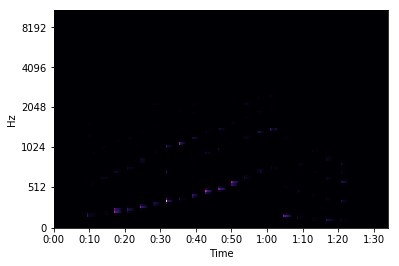

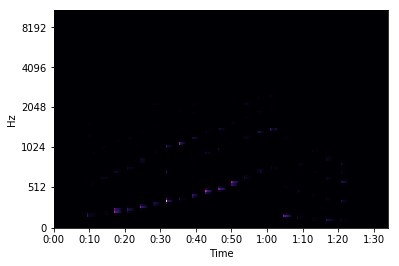

In [5]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import librosa.display
import numpy as np
from numpy.linalg import pinv
import simpleaudio as sa

print("Running")
sr, audio = wavfile.read('audio/homeFloor.wav')
print("Unpacked wav file")

audio = audio[:,0]
audio = audio.astype(np.float64)

plt.figure(1) 
mel_basis = librosa.filters.mel(sr, 2048)
S = np.abs(librosa.stft(audio, 2048, 512))**2.0
spec = mel_basis @ S
print(spec)
librosa.display.specshow(spec, y_axis='mel', x_axis='time')

plt.figure(2)
spec = librosa.feature.melspectrogram(audio, sr)
print(spec)
librosa.display.specshow(spec, y_axis='mel', x_axis='time')

plt.figure(3)
mel_basis = librosa.filters.mel(sr, 2048)
ft = librosa.stft(audio, 2048, 512)
angles = (mel_basis @ np.angle(ft))
angles = angles.reshape(np.concatenate((angles.shape, [1,])))
mel = mel_basis @ (np.abs(ft)**2.0)
mel = mel.reshape(np.concatenate((mel.shape, [1,])))
spec = np.concatenate((angles, mel, np.zeros(angles.shape)), 2)
#plt.imshow(spec)

plt.figure(4)

angles = spec[:,:,0].reshape(spec.shape[0:2])
angles = pinv(mel_basis) @ angles
abs = spec[:,:,1].reshape(spec.shape[0:2])
print(abs.min(), "abs's min")
print(pinv(mel_basis).min(), "pinv's min")
abs = pinv(mel_basis) @ abs
abs = abs.astype(np.complex128)
print(abs.min(), "final abs's min")
abs = np.sqrt(abs)
print(abs.shape, "abs")
print(angles.shape, "abs")
print(abs.min())
ft = abs*np.e**(0+1j*angles)
newaudio = librosa.istft(ft)
print(audio.shape)
print(newaudio.shape)
newaudio = newaudio.astype(np.int16)
audio = audio.astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, sr)
#play_obj = sa.play_buffer(newaudio, 1, 2, sr)
play_obj.wait_done()

In [ ]:
def displaySpectrogram(spec, figNum):
    

In [8]:
print("Running")
sample_rate, samples = wavfile.read('audio/homeFloor.wav')
print("Unpacked wav file")
samples = samples[:,0]

def fourier(x, win=2048, overlap=1028):
    fourier = fft(samples[0:0+2048])[0:1024].reshape(1024, 1, 1)
    for i in range(win-overlap, x.shape[0] - win-overlap, win-overlap):
        fourier = np.concatenate((fourier, fft(samples[i:i+2048])[0:1024].reshape(1024, 1, 1)), 1)
    print("Fourier transforms complete")
    return fourier
    
fourier = fourier(samples)

Running
Unpacked wav file
Fourier transforms complete


In [9]:
print(fourier)

[[[-6.35800000e+03+0.00000000e+00j]
  [-2.58700000e+03+0.00000000e+00j]
  [ 7.57000000e+02+0.00000000e+00j]
  ...
  [-1.66260000e+04+0.00000000e+00j]
  [-4.61550000e+04+0.00000000e+00j]
  [-6.46900000e+03+0.00000000e+00j]]

 [[-5.55977529e+03-1.19712700e+01j]
  [-5.54354350e+03-5.67527021e+02j]
  [ 9.06226847e+02+2.73217689e+02j]
  ...
  [-3.05981272e+04-1.47369192e+04j]
  [-5.54356361e+04-1.81957484e+04j]
  [-1.72526163e+04+3.47676670e+04j]]

 [[ 3.95592994e+03-7.79484348e+03j]
  [ 1.17616326e+04-2.06227380e+04j]
  [ 1.41676378e+04-2.61932715e+04j]
  ...
  [ 1.12747754e+04+1.65005986e+04j]
  [ 4.00529497e+04-1.13985144e+05j]
  [ 5.26400721e+04-1.95644453e+05j]]

 ...

 [[ 1.85515057e+01-8.52166811e+00j]
  [ 1.16405757e+01+3.77284551e+00j]
  [-2.10311088e+01-3.11907212e+00j]
  ...
  [ 9.79392844e+01+3.17841258e+00j]
  [-3.11744934e+02+2.29944932e+00j]
  [-5.47354267e+01-1.39459724e+00j]]

 [[ 5.69299425e+00+2.08215082e-01j]
  [ 1.90585769e+01+3.27522734e+00j]
  [-1.18647641e+01-1.21794

In [58]:
#Self-made spectrogram function

def selfspectrogram(x, win=2048, overlap=1024):
    fourier = fft(samples[0:0+win])[0:win/2.0].reshape(win/2.0, 1, 1)
    for i in range(win-overlap, x.shape[0] - win-overlap, win-overlap):
        fourier = np.concatenate((fourier, fft(samples[i:i+win])[0:win/2.0].reshape(win/2.0, 1, 1)), 1)
    print("Fourier transforms complete")
    mag = np.log(np.absolute(fourier)+1)
    mag /= mag.max()
    #mag = np.absolute(fourier)
    #mag = mag.max()-mag
    #mag = np.log(mag+1)
    #ag /= mag.max()
    print("Magnitude extraction complete")
    angles = (np.angle(fourier)+np.pi)/(2*np.pi)
    #angles = np.log(np.angle(fourier)+np.pi+1)
    #angles /= angles.max()
    print("Angle extraction complete")
    return np.flip(np.concatenate((angles, mag, np.zeros((win/2.0, fourier.shape[1], 1))), 2), 0)
    
    #Just shows magnitudes
    #return np.flip(np.concatenate((np.zeros((1024,fourier.shape[1], 1)), mag, np.zeros((1024,fourier.shape[1], 1))), 2), 0)

def addconj(x):
    length = x.shape[0]
    for i in range(1, length):
        x = np.concatenate((x,np.array([np.conj(x[length-i])])))
    return x;
    
def iselfspectrogram(magmax, *args, win=2048, overlap=1024):
    if(len(args)==1):
        mag = args[0][1]
        angles = args[0][0]
    else:
        mag = args[0]
        angles = args[1]
        angles = angles*2*np.pi-np.pi
        mag = np.exp(magmax*mag)-1
        
    fourier = mag*np.exp(1j*angles)
    reshaped = addconj(fourier[:,0]).reshape(fourier.shape[0], 1)
    for i in range(1, fourier.shape[1]):
        reshaped = np.concatenate((reshaped, addconj(fourier[:,i]).reshape(fourier.shape[0], 1), 1))
    return reshaped
    

print("Running")
sample_rate, samples = wavfile.read('audio/homeFloor.wav')
print("Unpacked wav file")
samples = samples[:,0]

mag = np.log(np.absolute(fourier)+1)
magmax = mag.max()
mag /= mag.max()
#mag = np.absolute(fourier)
#mag = mag.max()-mag
#mag = np.log(mag+1)
#mag /= mag.max()
print("Magnitude extraction complete")
angles = (np.angle(fourier)+np.pi)/(2*np.pi)
#angles = np.log(np.angle(fourier)+np.pi+1)
#angles /= angles.max()
print("Angle extraction complete")
#Shows magnitudes and angles
spectrogram = np.flip(np.concatenate((angles, mag, np.zeros((1024,fourier.shape[1], 1))), 2), 0);
#Just shows magnitudes
#spectrogram = np.flip(np.concatenate((np.zeros((1024,fourier.shape[1], 1)), mag, np.zeros((1024,fourier.shape[1], 1))), 2), 0);
#Just shows angles
#spectrogram = np.flip(np.concatenate((angles, np.zeros((1024,fourier.shape[1], 1)), np.zeros((1024,fourier.shape[1], 1))), 2), 0);

#spectrogram = selfspectrogram(samples)

print(fourier)
print(iselfspectrogram(magmax, spectrogram))
plt.imshow(spectrogram)
plt.figure(figsize=(1000,1000))
plt.show()
    

Running
Unpacked wav file
Magnitude extraction complete
Angle extraction complete
[[[-6.35800000e+03+0.00000000e+00j]
  [-2.58700000e+03+0.00000000e+00j]
  [ 7.57000000e+02+0.00000000e+00j]
  ...
  [-1.66260000e+04+0.00000000e+00j]
  [-4.61550000e+04+0.00000000e+00j]
  [-6.46900000e+03+0.00000000e+00j]]

 [[-5.55977529e+03-1.19712700e+01j]
  [-5.54354350e+03-5.67527021e+02j]
  [ 9.06226847e+02+2.73217689e+02j]
  ...
  [-3.05981272e+04-1.47369192e+04j]
  [-5.54356361e+04-1.81957484e+04j]
  [-1.72526163e+04+3.47676670e+04j]]

 [[ 3.95592994e+03-7.79484348e+03j]
  [ 1.17616326e+04-2.06227380e+04j]
  [ 1.41676378e+04-2.61932715e+04j]
  ...
  [ 1.12747754e+04+1.65005986e+04j]
  [ 4.00529497e+04-1.13985144e+05j]
  [ 5.26400721e+04-1.95644453e+05j]]

 ...

 [[ 1.85515057e+01-8.52166811e+00j]
  [ 1.16405757e+01+3.77284551e+00j]
  [-2.10311088e+01-3.11907212e+00j]
  ...
  [ 9.79392844e+01+3.17841258e+00j]
  [-3.11744934e+02+2.29944932e+00j]
  [-5.47354267e+01-1.39459724e+00j]]

 [[ 5.69299425e+

ValueError: cannot reshape array of size 4061 into shape (2031,1)

In [ ]:
for i in np.arange(1.00001, 1000, 20):
    print("Log base:", i)
    plt.figure(i)
    mag = np.absolute(fourier)+1
    mag = np.log(mag)/np.log(i)
    mag /= mag.max()
    spectrogram = np.flip(np.concatenate((np.zeros((1024,fourier.shape[1], 1)), mag, np.zeros((1024,fourier.shape[1], 1))), 2), 0);
    plt.imshow(spectrogram)
    plt.show()

In [70]:
testing = fft(samples[1356:1356+2048])
print(testing)
print(testing.shape)
def addconj(x):
    length = x.shape[0]
    for i in range(1, length):
        x = np.concatenate((x,np.array([np.conj(x[length-i])])))
    return x;
#testing = 
tested = addconj(testing[0:1024])
print(testing[0:1024])
print(testing)
print(addconj(testing[0:1024]))
print(testing.shape)
print(addconj(testing[0:1024]).shape)
print(tested[1023])
print(tested[1024])
print()
print(testing[0])
print(testing[1023])
print(testing[1024])
print(testing[1025])

[ -1676.            +0.j          -3002.17836436 -2860.22160736j
   8781.16037414+21746.36515372j ... -38149.25144554 +7958.80602369j
   8781.16037414-21746.36515372j  -3002.17836436 +2860.22160736j]
(2048,)
[-1676.        +0.00000000e+00j -3002.17836436-2.86022161e+03j
  8781.16037414+2.17463652e+04j ...   -53.06890828-1.31655683e+00j
   -57.46322044-1.64973989e+00j   -61.08528156-1.26033090e+01j]
[ -1676.            +0.j          -3002.17836436 -2860.22160736j
   8781.16037414+21746.36515372j ... -38149.25144554 +7958.80602369j
   8781.16037414-21746.36515372j  -3002.17836436 +2860.22160736j]
[ -1676.            +0.j          -3002.17836436 -2860.22160736j
   8781.16037414+21746.36515372j ... -38149.25144554 +7958.80602369j
   8781.16037414-21746.36515372j  -3002.17836436 +2860.22160736j]
(2048,)
(2047,)
(-61.08528155843169-12.60330904899547j)
(-61.08528155843169+12.60330904899547j)

(-1676+0j)
(-61.08528155843169-12.60330904899547j)
(-42+0j)
(-61.085281558430324+12.603309048994788j)

[[4.67133896e-04 1.90071624e-04 5.56181754e-05 ... 1.22154265e-03
  3.39109232e-03 4.75289269e-04]
 [4.08487812e-04 4.09423126e-04 6.95423584e-05 ... 2.49525541e-03
  4.28674918e-03 2.85165691e-03]
 [6.42233597e-04 1.74429200e-03 2.18794303e-03 ... 1.46831631e-03
  8.87667781e-03 1.48855685e-02]
 ...
 [1.49993635e-06 8.99054365e-07 1.56209499e-06 ... 7.19956673e-06
  2.29050939e-05 4.02281709e-06]
 [4.18554365e-07 1.42079487e-06 1.24926202e-06 ... 7.41871829e-06
  2.18535021e-05 3.90639790e-06]
 [1.05620039e-06 2.13622514e-06 1.04750988e-06 ... 6.65830886e-06
  2.30441266e-05 3.98032761e-06]]


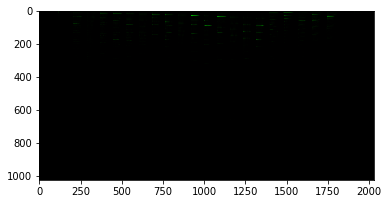

In [11]:
print(spectrogram[:,:,1])
plt.imshow(spectrogram)
plt.figure(figsize=(1000,1000))
plt.show()

In [14]:
%pip install librosa


The following command must be run outside of the IPython shell:

    $ pip install librosa

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more informations on how to install packages:

    https://docs.python.org/3/installing/


In [ ]:
import numpy as np

def spectrogram(x, fs=1.0, window=('tukey',.25), nperseg=None, noverlap=None,
                nfft=None, detrend='constant', return_onesided=True,
                scaling='density', axis=-1, mode='psd'):
    """
    Compute a spectrogram with consecutive Fourier transforms.
    Spectrograms can be used as a way of visualizing the change of a
    nonstationary signal's frequency content over time.
    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is
        passed to `get_window` to generate the window values, which are
        DFT-even by default. See `get_window` for a list of windows and
        required parameters. If `window` is array_like it will be used
        directly as the window and its length must be nperseg.
        Defaults to a Tukey window with shape parameter of 0.25.
    nperseg : int, optional
        Length of each segment. Defaults to None, but if window is str or
        tuple, is set to 256, and if window is array_like, is set to the
        length of the window.
    noverlap : int, optional
        Number of points to overlap between segments. If `None`,
        ``noverlap = nperseg // 8``. Defaults to `None`.
    nfft : int, optional
        Length of the FFT used, if a zero padded FFT is desired. If
        `None`, the FFT length is `nperseg`. Defaults to `None`.
    detrend : str or function or `False`, optional
        Specifies how to detrend each segment. If `detrend` is a
        string, it is passed as the `type` argument to the `detrend`
        function. If it is a function, it takes a segment and returns a
        detrended segment. If `detrend` is `False`, no detrending is
        done. Defaults to 'constant'.
    return_onesided : bool, optional
        If `True`, return a one-sided spectrum for real data. If
        `False` return a two-sided spectrum. Note that for complex
        data, a two-sided spectrum is always returned.
    scaling : { 'density', 'spectrum' }, optional
        Selects between computing the power spectral density ('density')
        where `Sxx` has units of V**2/Hz and computing the power
        spectrum ('spectrum') where `Sxx` has units of V**2, if `x`
        is measured in V and `fs` is measured in Hz. Defaults to
        'density'.
    axis : int, optional
        Axis along which the spectrogram is computed; the default is over
        the last axis (i.e. ``axis=-1``).
    mode : str, optional
        Defines what kind of return values are expected. Options are
        ['psd', 'complex', 'magnitude', 'angle', 'phase']. 'complex' is
        equivalent to the output of `stft` with no padding or boundary
        extension. 'magnitude' returns the absolute magnitude of the
        STFT. 'angle' and 'phase' return the complex angle of the STFT,
        with and without unwrapping, respectively.
    Returns
    -------
    f : ndarray
        Array of sample frequencies.
    t : ndarray
        Array of segment times.
    Sxx : ndarray
        Spectrogram of x. By default, the last axis of Sxx corresponds
        to the segment times.
    """
    modelist = ['psd', 'complex', 'magnitude', 'angle', 'phase']
    if mode not in modelist:
        raise ValueError('unknown value for mode {}, must be one of {}'
                         .format(mode, modelist))

    # need to set default for nperseg before setting default for noverlap below
    window, nperseg = _triage_segments(window, nperseg,
                                       input_length=x.shape[axis])

    # Less overlap than welch, so samples are more statisically independent
    if noverlap is None:
        noverlap = nperseg // 8

    if mode == 'psd':
        freqs, time, Sxx = _spectral_helper(x, x, fs, window, nperseg,
                                            noverlap, nfft, detrend,
                                            return_onesided, scaling, axis,
                                            mode='psd')

    else:
        freqs, time, Sxx = _spectral_helper(x, x, fs, window, nperseg,
                                            noverlap, nfft, detrend,
                                            return_onesided, scaling, axis,
                                            mode='stft')

        if mode == 'magnitude':
            Sxx = np.abs(Sxx)
        elif mode in ['angle', 'phase']:
            Sxx = np.angle(Sxx)
            if mode == 'phase':
                # Sxx has one additional dimension for time strides
                if axis < 0:
                    axis -= 1
                Sxx = np.unwrap(Sxx, axis=axis)

        # mode =='complex' is same as `stft`, doesn't need modification

    return freqs, time, Sxx



def _spectral_helper(x, y, fs=1.0, window='hann', nperseg=None, noverlap=None,
                     nfft=None, detrend='constant', return_onesided=True,
                     scaling='spectrum', axis=-1, mode='psd', boundary=None,
                     padded=False):
    """
    Calculate various forms of windowed FFTs for PSD, CSD, etc.
    This is a helper function that implements the commonality between
    the stft, psd, csd, and spectrogram functions. It is not designed to
    be called externally. The windows are not averaged over; the result
    from each window is returned.
    Parameters
    ---------
    x : array_like
        Array or sequence containing the data to be analyzed.
    y : array_like
        Array or sequence containing the data to be analyzed. If this is
        the same object in memory as `x` (i.e. ``_spectral_helper(x,
        x, ...)``), the extra computations are spared.
    fs : float, optional
        Sampling frequency of the time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is
        passed to `get_window` to generate the window values, which are
        DFT-even by default. See `get_window` for a list of windows and
        required parameters. If `window` is array_like it will be used
        directly as the window and its length must be nperseg. Defaults
        to a Hann window.
    nperseg : int, optional
        Length of each segment. Defaults to None, but if window is str or
        tuple, is set to 256, and if window is array_like, is set to the
        length of the window.
    noverlap : int, optional
        Number of points to overlap between segments. If `None`,
        ``noverlap = nperseg // 2``. Defaults to `None`.
    nfft : int, optional
        Length of the FFT used, if a zero padded FFT is desired. If
        `None`, the FFT length is `nperseg`. Defaults to `None`.
    detrend : str or function or `False`, optional
        Specifies how to detrend each segment. If `detrend` is a
        string, it is passed as the `type` argument to the `detrend`
        function. If it is a function, it takes a segment and returns a
        detrended segment. If `detrend` is `False`, no detrending is
        done. Defaults to 'constant'.
    return_onesided : bool, optional
        If `True`, return a one-sided spectrum for real data. If
        `False` return a two-sided spectrum. Note that for complex
        data, a two-sided spectrum is always returned.
    scaling : { 'density', 'spectrum' }, optional
        Selects between computing the cross spectral density ('density')
        where `Pxy` has units of V**2/Hz and computing the cross
        spectrum ('spectrum') where `Pxy` has units of V**2, if `x`
        and `y` are measured in V and `fs` is measured in Hz.
        Defaults to 'density'
    axis : int, optional
        Axis along which the FFTs are computed; the default is over the
        last axis (i.e. ``axis=-1``).
    mode: str {'psd', 'stft'}, optional
        Defines what kind of return values are expected. Defaults to
        'psd'.
    boundary : str or None, optional
        Specifies whether the input signal is extended at both ends, and
        how to generate the new values, in order to center the first
        windowed segment on the first input point. This has the benefit
        of enabling reconstruction of the first input point when the
        employed window function starts at zero. Valid options are
        ``['even', 'odd', 'constant', 'zeros', None]``. Defaults to
        `None`.
    padded : bool, optional
        Specifies whether the input signal is zero-padded at the end to
        make the signal fit exactly into an integer number of window
        segments, so that all of the signal is included in the output.
        Defaults to `False`. Padding occurs after boundary extension, if
        `boundary` is not `None`, and `padded` is `True`.
    Returns
    -------
    freqs : ndarray
        Array of sample frequencies.
    t : ndarray
        Array of times corresponding to each data segment
    result : ndarray
        Array of output data, contents dependent on *mode* kwarg.
    Notes
    -----
    Adapted from matplotlib.mlab
    .. versionadded:: 0.16.0
    """
    if mode not in ['psd', 'stft']:
        raise ValueError("Unknown value for mode %s, must be one of: "
                         "{'psd', 'stft'}" % mode)

    boundary_funcs = {'even': even_ext,
                      'odd': odd_ext,
                      'constant': const_ext,
                      'zeros': zero_ext,
                      None: None}

    if boundary not in boundary_funcs:
        raise ValueError("Unknown boundary option '{0}', must be one of: {1}"
                          .format(boundary, list(boundary_funcs.keys())))

    # If x and y are the same object we can save ourselves some computation.
    same_data = y is x

    if not same_data and mode != 'psd':
        raise ValueError("x and y must be equal if mode is 'stft'")

    axis = int(axis)

    # Ensure we have np.arrays, get outdtype
    x = np.asarray(x)
    if not same_data:
        y = np.asarray(y)
        outdtype = np.result_type(x, y, np.complex64)
    else:
        outdtype = np.result_type(x, np.complex64)

    if not same_data:
        # Check if we can broadcast the outer axes together
        xouter = list(x.shape)
        youter = list(y.shape)
        xouter.pop(axis)
        youter.pop(axis)
        try:
            outershape = np.broadcast(np.empty(xouter), np.empty(youter)).shape
        except ValueError:
            raise ValueError('x and y cannot be broadcast together.')

    if same_data:
        if x.size == 0:
            return np.empty(x.shape), np.empty(x.shape), np.empty(x.shape)
    else:
        if x.size == 0 or y.size == 0:
            outshape = outershape + (min([x.shape[axis], y.shape[axis]]),)
            emptyout = np.rollaxis(np.empty(outshape), -1, axis)
            return emptyout, emptyout, emptyout

    if x.ndim > 1:
        if axis != -1:
            x = np.rollaxis(x, axis, len(x.shape))
            if not same_data and y.ndim > 1:
                y = np.rollaxis(y, axis, len(y.shape))

    # Check if x and y are the same length, zero-pad if necessary
    if not same_data:
        if x.shape[-1] != y.shape[-1]:
            if x.shape[-1] < y.shape[-1]:
                pad_shape = list(x.shape)
                pad_shape[-1] = y.shape[-1] - x.shape[-1]
                x = np.concatenate((x, np.zeros(pad_shape)), -1)
            else:
                pad_shape = list(y.shape)
                pad_shape[-1] = x.shape[-1] - y.shape[-1]
                y = np.concatenate((y, np.zeros(pad_shape)), -1)

    if nperseg is not None:  # if specified by user
        nperseg = int(nperseg)
        if nperseg < 1:
            raise ValueError('nperseg must be a positive integer')

    # parse window; if array like, then set nperseg = win.shape
    win, nperseg = _triage_segments(window, nperseg,input_length=x.shape[-1])

    if nfft is None:
        nfft = nperseg
    elif nfft < nperseg:
        raise ValueError('nfft must be greater than or equal to nperseg.')
    else:
        nfft = int(nfft)

    if noverlap is None:
        noverlap = nperseg//2
    else:
        noverlap = int(noverlap)
    if noverlap >= nperseg:
        raise ValueError('noverlap must be less than nperseg.')
    nstep = nperseg - noverlap

    # Padding occurs after boundary extension, so that the extended signal ends
    # in zeros, instead of introducing an impulse at the end.
    # I.e. if x = [..., 3, 2]
    # extend then pad -> [..., 3, 2, 2, 3, 0, 0, 0]
    # pad then extend -> [..., 3, 2, 0, 0, 0, 2, 3]

    if boundary is not None:
        ext_func = boundary_funcs[boundary]
        x = ext_func(x, nperseg//2, axis=-1)
        if not same_data:
            y = ext_func(y, nperseg//2, axis=-1)

    if padded:
        # Pad to integer number of windowed segments
        # I.e make x.shape[-1] = nperseg + (nseg-1)*nstep, with integer nseg
        nadd = (-(x.shape[-1]-nperseg) % nstep) % nperseg
        zeros_shape = list(x.shape[:-1]) + [nadd]
        x = np.concatenate((x, np.zeros(zeros_shape)), axis=-1)
        if not same_data:
            zeros_shape = list(y.shape[:-1]) + [nadd]
            y = np.concatenate((y, np.zeros(zeros_shape)), axis=-1)

    # Handle detrending and window functions
    if not detrend:
        def detrend_func(d):
            return d
    elif not hasattr(detrend, '__call__'):
        def detrend_func(d):
            return signaltools.detrend(d, type=detrend, axis=-1)
    elif axis != -1:
        # Wrap this function so that it receives a shape that it could
        # reasonably expect to receive.
        def detrend_func(d):
            d = np.rollaxis(d, -1, axis)
            d = detrend(d)
            return np.rollaxis(d, axis, len(d.shape))
    else:
        detrend_func = detrend

    if np.result_type(win,np.complex64) != outdtype:
        win = win.astype(outdtype)

    if scaling == 'density':
        scale = 1.0 / (fs * (win*win).sum())
    elif scaling == 'spectrum':
        scale = 1.0 / win.sum()**2
    else:
        raise ValueError('Unknown scaling: %r' % scaling)

    if mode == 'stft':
        scale = np.sqrt(scale)

    if return_onesided:
        if np.iscomplexobj(x):
            sides = 'twosided'
            warnings.warn('Input data is complex, switching to '
                          'return_onesided=False')
        else:
            sides = 'onesided'
            if not same_data:
                if np.iscomplexobj(y):
                    sides = 'twosided'
                    warnings.warn('Input data is complex, switching to '
                                  'return_onesided=False')
    else:
        sides = 'twosided'

    if sides == 'twosided':
        freqs = fftpack.fftfreq(nfft, 1/fs)
    elif sides == 'onesided':
        freqs = np.fft.rfftfreq(nfft, 1/fs)

    # Perform the windowed FFTs
    result = _fft_helper(x, win, detrend_func, nperseg, noverlap, nfft, sides)

    if not same_data:
        # All the same operations on the y data
        result_y = _fft_helper(y, win, detrend_func, nperseg, noverlap, nfft,
                               sides)
        result = np.conjugate(result) * result_y
    elif mode == 'psd':
        result = np.conjugate(result) * result

    result *= scale
    if sides == 'onesided' and mode == 'psd':
        if nfft % 2:
            result[..., 1:] *= 2
        else:
            # Last point is unpaired Nyquist freq point, don't double
            result[..., 1:-1] *= 2

    time = np.arange(nperseg/2, x.shape[-1] - nperseg/2 + 1,
                     nperseg - noverlap)/float(fs)
    if boundary is not None:
        time -= (nperseg/2) / fs

    result = result.astype(outdtype)

    # All imaginary parts are zero anyways
    if same_data and mode != 'stft':
        result = result.real

    # Output is going to have new last axis for time/window index, so a
    # negative axis index shifts down one
    if axis < 0:
        axis -= 1

    # Roll frequency axis back to axis where the data came from
    result = np.rollaxis(result, -1, axis)

    return freqs, time, result


def _fft_helper(x, win, detrend_func, nperseg, noverlap, nfft, sides):
    """
    Calculate windowed FFT, for internal use by
    scipy.signal._spectral_helper
    This is a helper function that does the main FFT calculation for
    `_spectral helper`. All input validation is performed there, and the
    data axis is assumed to be the last axis of x. It is not designed to
    be called externally. The windows are not averaged over; the result
    from each window is returned.
    Returns
    -------
    result : ndarray
        Array of FFT data
    Notes
    -----
    Adapted from matplotlib.mlab
    .. versionadded:: 0.16.0
    """
    # Created strided array of data segments
    if nperseg == 1 and noverlap == 0:
        result = x[..., np.newaxis]
    else:
        # http://stackoverflow.com/a/5568169
        step = nperseg - noverlap
        shape = x.shape[:-1]+((x.shape[-1]-noverlap)//step, nperseg)
        strides = x.strides[:-1]+(step*x.strides[-1], x.strides[-1])
        result = np.lib.stride_tricks.as_strided(x, shape=shape,
                                                 strides=strides)

    # Detrend each data segment individually
    # JZ: subtracts the mean of the data from each data point
    result = detrend_func(result)

    # Apply window by multiplication
    result = win * result

    # Perform the fft. Acts on last axis by default. Zero-pads automatically
    if sides == 'twosided':
        func = fftpack.fft
    else:
        result = result.real
        func = np.fft.rfft
    result = func(result, n=nfft)

    return result

def _triage_segments(window, nperseg, input_length):
    """
    JZ: basically checks if window, n per segments, and input_length match; 
        raises error otherwise
    Parses window and nperseg arguments for spectrogram and _spectral_helper.
    This is a helper function, not meant to be called externally.
    Parameters
    ---------
    window : string, tuple, or ndarray
        If window is specified by a string or tuple and nperseg is not
        specified, nperseg is set to the default of 256 and returns a window of
        that length.
        If instead the window is array_like and nperseg is not specified, then
        nperseg is set to the length of the window. A ValueError is raised if
        the user supplies both an array_like window and a value for nperseg but
        nperseg does not equal the length of the window.
    nperseg : int
        Length of each segment
    input_length: int
        Length of input signal, i.e. x.shape[-1]. Used to test for errors.
    Returns
    -------
    win : ndarray
        window. If function was called with string or tuple than this will hold
        the actual array used as a window.
    nperseg : int
        Length of each segment. If window is str or tuple, nperseg is set to
        256. If window is array_like, nperseg is set to the length of the 
        window.
    """

    #parse window; if array like, then set nperseg = win.shape
    if isinstance(window, string_types) or isinstance(window, tuple):
        # if nperseg not specified
        if nperseg is None:
            nperseg = 256  # then change to default
        if nperseg > input_length:
            warnings.warn('nperseg = {0:d} is greater than input length '
                              ' = {1:d}, using nperseg = {1:d}'
                              .format(nperseg, input_length))
            nperseg = input_length
        win = get_window(window, nperseg)
    else:
        win = np.asarray(window)
        if len(win.shape) != 1:
            raise ValueError('window must be 1-D')
        if input_length < win.shape[-1]:
            raise ValueError('window is longer than input signal')
        if nperseg is None:
            nperseg = win.shape[0]
        elif nperseg is not None:
            if nperseg != win.shape[0]:
                raise ValueError("value specified for nperseg is different from"
                                 " length of window")
    return win, nperseg

def get_window(window, Nx, fftbins=True):
    """
    Return a window.
    Parameters
    ----------
    window : string, float, or tuple
        The type of window to create. See below for more details.
    Nx : int
        The number of samples in the window.
    fftbins : bool, optional
        If True (default), create a "periodic" window, ready to use with
        `ifftshift` and be multiplied by the result of an FFT (see also
        `fftpack.fftfreq`).
        If False, create a "symmetric" window, for use in filter design.
    Returns
    -------
    get_window : ndarray
        Returns a window of length `Nx` and type `window`
    Notes
    -----
    Window types:
        `boxcar`, `triang`, `blackman`, `hamming`, `hann`, `bartlett`,
        `flattop`, `parzen`, `bohman`, `blackmanharris`, `nuttall`,
        `barthann`, `kaiser` (needs beta), `gaussian` (needs standard
        deviation), `general_gaussian` (needs power, width), `slepian`
        (needs width), `dpss` (needs normalized half-bandwidth),
        `chebwin` (needs attenuation), `exponential` (needs decay scale),
        `tukey` (needs taper fraction)
    If the window requires no parameters, then `window` can be a string.
    If the window requires parameters, then `window` must be a tuple
    with the first argument the string name of the window, and the next
    arguments the needed parameters.
    If `window` is a floating point number, it is interpreted as the beta
    parameter of the `kaiser` window.
    Each of the window types listed above is also the name of
    a function that can be called directly to create a window of
    that type.
    Examples
    --------
    >>> from scipy import signal
    >>> signal.get_window('triang', 7)
    array([ 0.125,  0.375,  0.625,  0.875,  0.875,  0.625,  0.375])
    >>> signal.get_window(('kaiser', 4.0), 9)
    array([ 0.08848053,  0.29425961,  0.56437221,  0.82160913,  0.97885093,
            0.97885093,  0.82160913,  0.56437221,  0.29425961])
    >>> signal.get_window(4.0, 9)
    array([ 0.08848053,  0.29425961,  0.56437221,  0.82160913,  0.97885093,
            0.97885093,  0.82160913,  0.56437221,  0.29425961])
    """
    sym = not fftbins
    try:
        beta = float(window)
    except (TypeError, ValueError):
        args = ()
        if isinstance(window, tuple):
            winstr = window[0]
            if len(window) > 1:
                args = window[1:]
        elif isinstance(window, string_types):
            if window in _needs_param:
                raise ValueError("The '" + window + "' window needs one or "
                                 "more parameters -- pass a tuple.")
            else:
                winstr = window
        else:
            raise ValueError("%s as window type is not supported." %
                             str(type(window)))

        try:
            winfunc = _win_equiv[winstr]
        except KeyError:
            raise ValueError("Unknown window type.")

        params = (Nx,) + args + (sym,)
    else:
        winfunc = kaiser
        params = (Nx, beta, sym)

    return winfunc(*params)

In [2]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
import numpy as np

sample_rate, samples = wavfile.read('audio/homeFloor.wav')
#samples = samples[44100*5 : 44100*15, 0]
samples = samples[:,0]
samples = samples.astype(np.floating)
print("Sample rate: ", sample_rate)
print("Audio raw array: ", samples)
spectrogram = librosa.feature.melspectrogram(samples, sample_rate)
print("Shape of spectrogram: ", spectrogram.shape)
print("Raw spectrogram: ", spectrogram)
spectrogram = spectrogram[ : 40, :]

plt.figure(figsize=(10, 4))
#librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', fmax=100000, x_axis='time')
librosa.display.specshow(librosa.power_to_db(spectrogram), y_axis='mel', fmax=100000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

"""print(sample_rate)
print(samples)
channel1 = samples[ : , 0]
print(channel1)
print(channel1.size)

plt.pcolormesh(times, frequencies, spectrogram)

plt.imshow(spectrogram, aspect="auto")
plt.gca().invert_yaxis()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.figure(figsize=(10,10))
plt.show()"""

ImportError: No module named 'librosa'

In [3]:
import numpy as np
import soundfile as sf

data, fs = sf.read("audio/homeFloor.wav", dtype="float32")
print(data)
print(data.size)


[[-0.00073242 -0.00073242]
 [-0.00134277 -0.00134277]
 [-0.00073242 -0.00073242]
 ...
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
4149120
